# EDA Details

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sn

pd.set_option('display.max_columns', None)

Before our analysis, we need to know which featues in the SRA run table are more suitable to put in our model and get familliar with the gene matrix we have. To do this, we need to perform exploratory data analysis on the SRA run table and the gene matrix. 


## SRA run table

First, let us explore the SRA run table. Because there are too many features in this table, we selected only the columns that are relevant to our analysis (shown below).

As a reference, here are the brief introductions of some of the domain-specific features:

* NIA-R: The modified NIA-Reagan diagnosis of Alzheimer's disease is based on consensus recommendations for postmortem diagnosis of Alzheimer's disease. The criteria rely on both neurofibrillary tangles (Braak) and neuritic plaques (CERAD).


* LB stage: Lewy body dementia, also known as dementia with Lewy bodies, is the second most common type of progressive dementia after Alzheimer's disease dementia. Protein deposits, called Lewy bodies, develop in nerve cells in the brain regions involved in thinking, memory and movement (motor control). There are two diagnoses of LBD—dementia with Lewy bodies (DLB) and Parkinson's disease dementia. The earliest signs differ but reflect the same biological changes in the brain. Over time, people with dementia with Lewy bodies or Parkinson's disease dementia may develop similar symptoms.


* Braak staging refers to two methods used to classify the degree of pathology in Parkinson's disease and Alzheimer's disease. These methods are used both in research and for the clinical diagnosis of these diseases and are obtained by performing an autopsy of the brain.

In [4]:
features = ['expired_age', 'sex', 'PMI', 'sn_depigmentation', 'Braak score', 'TangleTotal', 'Plaque density', 
            'PlaqueTotal', 'CONDITION', 'BIOFLUID', 'TRANSCRIPTOME READS', 'REFERENCE GENOME READS', 
            'TRANSCRIPTOME GENOME RATIO', 'PlaqueF', 'PlaqueT', 'PlaqueH', 'PlaqueE', 'TangleF', 
            'TangleT', 'TangleH', 'TangleE', 'NIA-R', 'LB Stage', 'Run']

In [5]:
sra = pd.read_csv('../test/testdata/SraRunTable.csv', usecols=features)
sra.head()

,CONDITION,BIOFLUID,TRANSCRIPTOME READS,REFERENCE GENOME READS,TRANSCRIPTOME GENOME RATIO,expired_age,PMI,PlaqueF,PlaqueT,PlaqueH,PlaqueE,PlaqueTotal,Plaque density,TangleF,TangleT,TangleH,TangleE,TangleTotal,Braak score,NIA-R,LB Stage,sn_depigmentation,Run,sex
0,Healthy Control,Cerebrospinal fluid,6883461,6923368,0.994236,94,2.50,3.0,3.00,3.0,3.0,15.00,frequent,1.0,3.00,3.0,3.0,12.00,IV,criteria not met,No Lewy bodies,none,SRR1568567,male
1,Parkinson's Disease,Serum,2904451,2953867,0.983271,79,6.00,0.0,1.75,0.0,0.0,2.75,sparse,0.0,0.75,1.5,1.0,3.25,II,criteria not met,Limbic type,severe,SRR1568730,female
2,Alzheimer's Disease,Serum,12132405,12781881,0.949188,81,2.50,2.5,2.50,2.5,2.0,11.50,frequent,1.6,2.50,3.0,3.0,11.10,V,high,No Lewy bodies,mild,SRR1568666,female
3,Parkinson's Disease,Cerebrospinal fluid,5560256,5622788,0.988879,79,2.50,1.5,2.00,1.0,1.5,7.50,moderate,0.0,0.50,1.0,1.5,3.00,II,low,Neocortical type,severe,SRR1568510,male
4,Parkinson's Disease,Cerebrospinal fluid,12131859,12219540,0.992825,82,4.16,0.0,0.00,0.0,0.0,0.00,zero,0.0,0.50,3.0,3.0,6.50,III,criteria not met,Limbic type,severe,SRR1568518,female


The first question is that does each subject has both cerebrospinal fluid and serum sample? Or there is only one sample from a single area of interest for one subject?

As we can see in the figure below, the anwser is the latter. So we need to keep in mind that there may exist cross-subject differences for samples of different biofluids

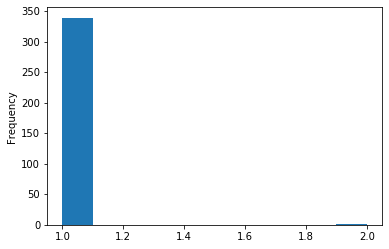

In [6]:
# Do all subjects have both CSF and serum?

# Different population
sra.Run.value_counts().plot.hist()

So, we broke down the samples into two groups based on biofluid, and then looked at the distribution of other variables, namely gender, expired age, PMI, total number of plaques, and total number of tangles.

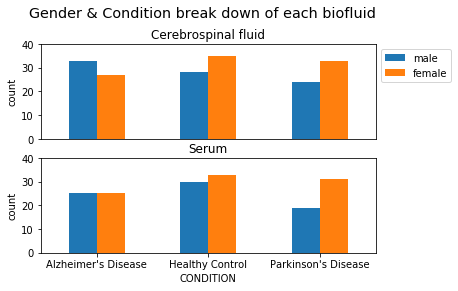

In [8]:
#sample furthur break-down by gender
cnt_summary_CSF = sra[sra['BIOFLUID']=='Cerebrospinal fluid'][['CONDITION', 'BIOFLUID', 'sex']].groupby(['CONDITION', 'sex']).count().unstack()
cnt_summary_serum = sra[sra['BIOFLUID']=='Serum'][['CONDITION', 'BIOFLUID', 'sex']].groupby(['CONDITION', 'sex']).count().unstack()
fig, (ax1, ax2) = plt.subplots(2, 1)
cnt_summary_CSF.plot.bar(ax = ax1)
ax1.legend(['male', 'female'], bbox_to_anchor=(1, 1))
ax1.set_title('Cerebrospinal fluid')
ax1.set_ylim(0,40)
ax1.set_ylabel('count')
ax1.xaxis.set_visible(False)

cnt_summary_serum.plot.bar(ax = ax2)
ax2.set_title('Serum')
ax2.legend().remove()
ax2.set_ylim(0,40)
ax2.set_ylabel('count')
plt.xticks(rotation = 0)
fig.suptitle('Gender & Condition break down of each biofluid', fontsize='x-large')
fig.subplots_adjust(top=0.85)

/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


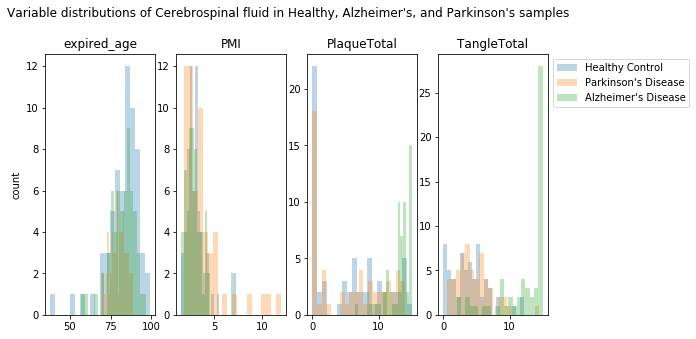

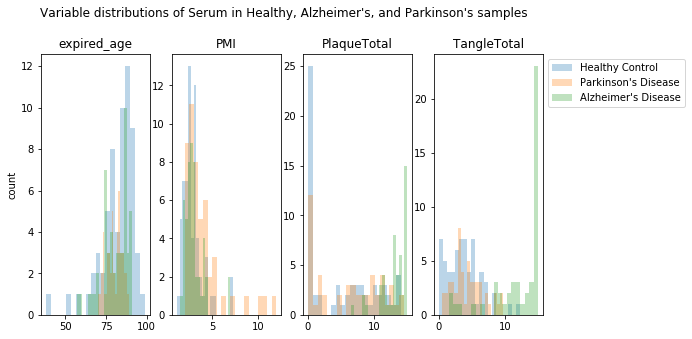

In [9]:
# numerical variables distribution
conditions = sra.CONDITION.unique()
biofluids = sra.BIOFLUID.unique()
num_bins = 20
variables = ['expired_age', 'PMI', 'PlaqueTotal', 'TangleTotal']
for i in biofluids:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_figheight(5)
    fig.set_figwidth(9)
    ax_arr = [ax1, ax2, ax3, ax4]
    fig.suptitle('Variable distributions of %s in Healthy, Alzheimer\'s, and Parkinson\'s samples' % i)
    fig.subplots_adjust(top=0.85)
    for j in conditions:
        for k in range(len(variables)):
            data = sra.loc[(sra['CONDITION']==j) & (sra['BIOFLUID']==i)][variables[k]]
            ax = ax_arr[k]
            ax.hist(data, bins=num_bins,label=j, alpha = 0.3)
            ax.set_title(variables[k])
            if k==0:
                ax.set_ylabel('count')
        ax.legend(bbox_to_anchor=(1, 1))
            
            

As shown above, although the distributions have slight differences, the distinction between the distribution of the samples of cerebrospinal fluid and that of serum is not significant. 

As mentioned previously, NIA-R is a measurement for diagnosing Alzheimer's disease. We wanted to validate if the values of the samples in our dataset reflect this claim.

Text(0.5, 1.0, "NIA-R Distribution of Healthy, Alzheimer's, and Parkinson's samples")

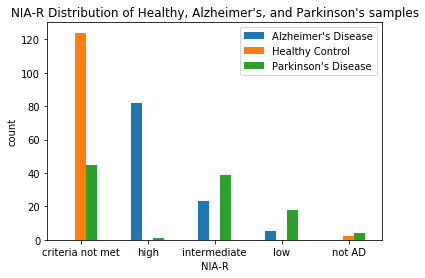

In [24]:
# distribution of NIA-R droken down by conditions

conditions = ['Alzheimer\'s Disease', 'Healthy Control', 'Parkinson\'s Disease']
nia_r = sra.groupby(['NIA-R','CONDITION']).size().to_frame()
nia_r.unstack().plot(kind='bar')
plt.legend(conditions)
plt.xticks(rotation = 0)
plt.ylabel('count')
plt.title('NIA-R Distribution of Healthy, Alzheimer\'s, and Parkinson\'s samples')

In the chart above, we saw that all the healthy control samples are either under the category "criteria not met" or "no AD". Surprisingly, although it is expected that most of the AD samples are under the category "high" there are some of the PD samples under "intermediate" and "low" categories. It might suggest that there exist some commonalities between AD and PD.

Then we did the similar thing for other measurements like LB stage, Substantia Nigra Depigmentation, and Braak score.

Text(0.5, 1.0, "LB Stage Distribution of Healthy, Alzheimer's, and Parkinson's samples")

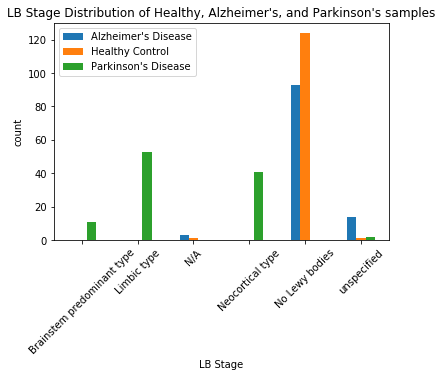

In [25]:
# distribution of LB Stage broken down by conditions
lb_mapper = {'LB pathology unspecified or not further assessed': 'unspecified', np.nan: 'N/A'}
sra['LB Stage'] = sra['LB Stage'].replace(lb_mapper)
lb_stage = sra.groupby(['LB Stage', 'CONDITION']).size().to_frame()
lb_stage.unstack().plot(kind='bar')
plt.legend(conditions)
plt.xticks(rotation = 45)
plt.ylabel('count')
plt.title('LB Stage Distribution of Healthy, Alzheimer\'s, and Parkinson\'s samples')

Since lewy bodies are closely associated with Parkinson's disease, it is reasonable to see there are only Parkinson's samples in the LB stage categories. Among those samples, most of them are under limbic type and neocortical type. Under "No lewy bodies" category, there are no Parkinson's patients, which further proved that lewy bodies is specific to Parkinson's disease in our dataset.

Text(0.5, 1.0, "Substantia Nigra Depigmentation Score Distribution of Healthy, Alzheimer's, and Parkinson's samples")

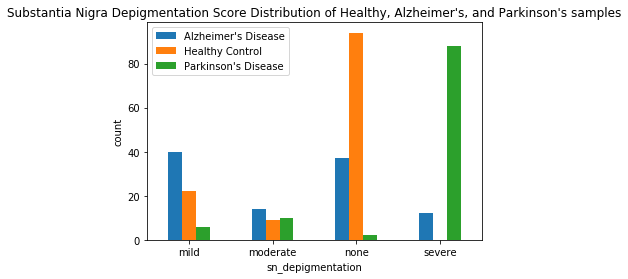

In [18]:
# sn depigmentation distributions broken down by conditions
# double check
conditions = ['Alzheimer\'s Disease', 'Healthy Control', 'Parkinson\'s Disease']
sn_dp = sra.groupby(['sn_depigmentation', 'CONDITION']).size().to_frame()
sn_dp.unstack().plot(kind='bar')
plt.legend(conditions)
plt.xticks(rotation = 0)
plt.ylabel('count')
plt.title('Substantia Nigra Depigmentation Score Distribution of Healthy, Alzheimer\'s, and Parkinson\'s samples')

According to [Peowe et al.](https://www.nature.com/articles/nrdp201713#Sec3), compared to control, parkinson's disease is defined by sn depigmentation. So it is intuitive to see the parkinson's group has the most severe cases. However, same as what happened in NIA-R distribution, there is not a clear separation between AD and PD, namely, there are still some AD patients in the "mild", "moderate", or even "severe" categories.


(Poewe, W., Seppi,K., Tanner, C. et al. Parkinson disease. Nat Rev Dis Primers 3, 17013 (2017). https://doi.org/10.1038/nrdp.2017.13)

Text(0.5, 1.0, "Braak Score Distribution of Healthy, Alzheimer's, and Parkinson's samples")

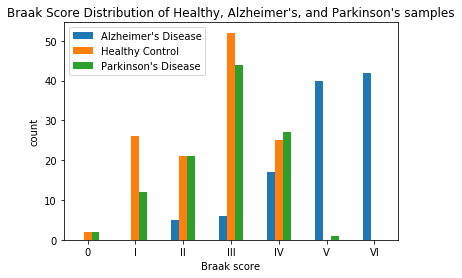

In [21]:
#braak distribution
conditions = ['Alzheimer\'s Disease', 'Healthy Control', 'Parkinson\'s Disease']
bs_cnts = sra.groupby(['Braak score','CONDITION']).size().to_frame()
bs_cnts.unstack().plot(kind='bar')
plt.legend(conditions)
plt.xticks(rotation = 0)
plt.ylabel('count')
plt.title('Braak Score Distribution of Healthy, Alzheimer\'s, and Parkinson\'s samples')

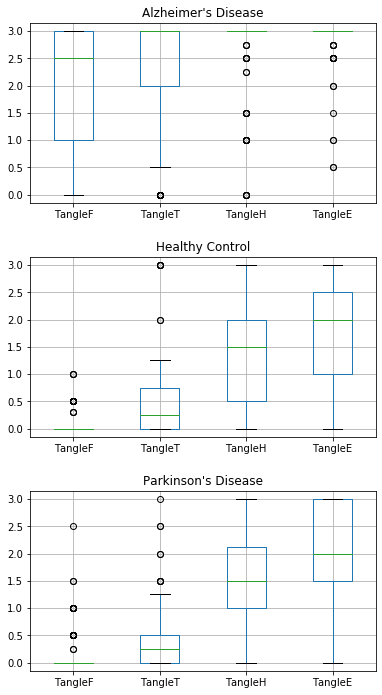

In [9]:
# Tangle counts distribution in each brain region broken down by contidions
plaques = sra[['CONDITION', 'TangleF', 'TangleT', 'TangleH', 'TangleE']]
plaques.groupby('CONDITION').boxplot(figsize=(6, 12), layout=(3, 1))
plt.subplots_adjust(hspace = 0.3)

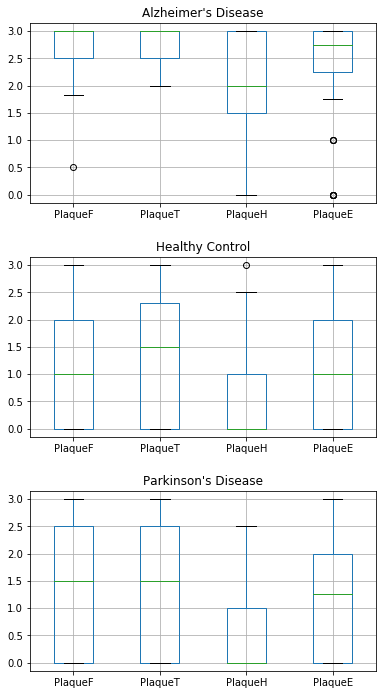

In [10]:
# Plaque counts distribution in each brain region broken down by contidions
plaques = sra[['CONDITION', 'PlaqueF', 'PlaqueT', 'PlaqueH', 'PlaqueE']]
plaques.groupby('CONDITION').boxplot(figsize=(6, 12), layout=(3, 1))
plt.subplots_adjust(hspace = 0.3)

In [11]:
# Correlation of plaque total and tangle total break-down
sra.groupby('CONDITION')[['PlaqueTotal', 'TangleTotal']].corr()

PlaqueTotal  TangleTotal
CONDITION                                                
Alzheimer's Disease PlaqueTotal     1.000000     0.678682
                    TangleTotal     0.678682     1.000000
Healthy Control     PlaqueTotal     1.000000     0.424932
                    TangleTotal     0.424932     1.000000
Parkinson's Disease PlaqueTotal     1.000000     0.491109
                    TangleTotal     0.491109     1.000000

In [17]:
sn_dp.unstack()

0                                    
CONDITION         Alzheimer's Disease Healthy Control Parkinson's Disease
sn_depigmentation                                                        
mild                             40.0            22.0                 6.0
moderate                         14.0             9.0                10.0
none                             37.0            94.0                 2.0
severe                           12.0             NaN                88.0

In [14]:
# redundant features?
# distributions of plaque total values correspond to each plaque density category
pd.DataFrame(group.describe().rename(columns={'PlaqueTotal':name}).squeeze()  for name, group in sra[['Plaque density', 'PlaqueTotal']].groupby('Plaque density'))


,count,mean,std,min,25%,50%,75%,max
frequent,115.0,13.227217,1.813332,6.50,12.915,13.50,14.875,15.00
moderate,95.0,9.539579,2.865883,1.75,7.250,9.75,11.500,14.25
sparse,47.0,5.507447,3.395009,0.50,2.475,5.30,7.500,12.00
zero,86.0,0.462209,1.685805,0.00,0.000,0.00,0.000,12.75


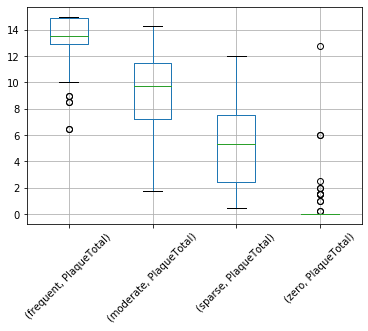

In [15]:
sra[['Plaque density', 'PlaqueTotal']].groupby('Plaque density').boxplot(subplots=False,rot=45)

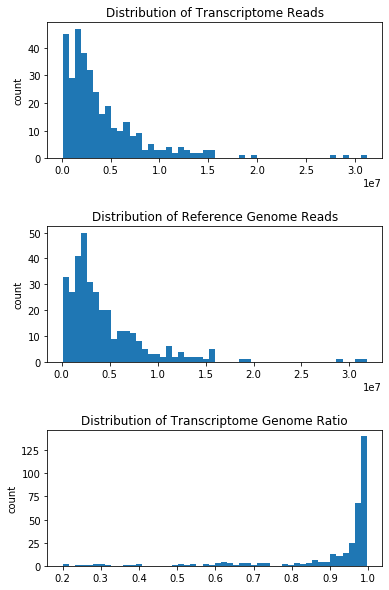

In [6]:
# Distributions of reads of all samples
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.hist(sra['TRANSCRIPTOME READS'], bins=50)
ax1.set_title('Distribution of Transcriptome Reads')
ax1.set_ylabel('count')
ax2.hist(sra['REFERENCE GENOME READS'], bins=50)
ax2.set_title('Distribution of Reference Genome Reads')
ax2.set_ylabel('count')
ax3.hist(sra['TRANSCRIPTOME GENOME RATIO'], bins=50)
ax3.set_title('Distribution of Transcriptome Genome Ratio')
ax3.set_ylabel('count')
fig.subplots_adjust(hspace = 0.5)
fig.set_figheight(10)

In [20]:
bs_cnts.unstack()

0                                    
CONDITION   Alzheimer's Disease Healthy Control Parkinson's Disease
Braak score                                                        
0                           NaN             2.0                 2.0
I                           NaN            26.0                12.0
II                          5.0            21.0                21.0
III                         6.0            52.0                44.0
IV                         17.0            25.0                27.0
V                          40.0             NaN                 1.0
VI                         42.0             NaN                 NaN

In [2]:
gm = pd.read_csv('../data/out/gene_matrix.tsv', sep='\t', index_col=0)
gm_full = pd.read_csv('../data/out/gene_matrix_full.tsv', sep='\t', index_col=0)
gm.head()

,SRR1568461,SRR1568545,SRR1568370,SRR1568515,SRR1568742,SRR1568430,SRR1568625,SRR1568660,SRR1568427,SRR1568576,SRR1568424,SRR1568748,SRR1568599,SRR1568636,SRR1568408,SRR1568437,SRR1568482,SRR1568746,SRR1568727,SRR1568603,SRR1568693,SRR1568386,SRR1568715,SRR1568626,SRR1568511,SRR1568438,SRR1568406,SRR1568705,SRR1568605,SRR1568553,SRR1568713,SRR1568483,SRR1568738,SRR1568525,SRR1568722,SRR1568707,SRR1568572,SRR1568428,SRR1568736,SRR1568414,SRR1568672,SRR1568518,SRR1568547,SRR1568368,SRR1568687,SRR1568369,SRR1568448,SRR1568537,SRR1568499,SRR1568614,SRR1568432,SRR1568468,SRR1568463,SRR1568526,SRR1568593,SRR1568538,SRR1568665,SRR1568648,SRR1568504,SRR1568677,SRR1568447,SRR1568490,SRR1568627,SRR1568669,SRR1568486,SRR1568395,SRR1568517,SRR1568633,SRR1568697,SRR1568501,SRR1568601,SRR1568480,SRR1568398,SRR1568505,SRR1568749,SRR1568728,SRR1568558,SRR1568717,SRR1568560,SRR1568666,SRR1568721,SRR1568613,SRR1568658,SRR1568702,SRR1568685,SRR1568443,SRR1568495,SRR1568524,SRR1568673,SRR1568600,SRR1568718,SRR1568387,SRR1568723,SRR1568612,SRR1568670,SRR1568401,SRR1568418,SRR1568527,SRR1568470,SRR1568534,SRR1568716,SRR1568528,SRR1568440,SRR1568584,SRR1568634,SRR1568541,SRR1568607,SRR1568651,SRR1568735,SRR1568460,SRR1568439,SRR1568652,SRR1568585,SRR1568744,SRR1568679,SRR1568616,SRR1568493,SRR1568734,SRR1568695,SRR1568535,SRR1568646,SRR1568516,SRR1568579,SRR1568471,SRR1568700,SRR1568611,SRR1568563,SRR1568578,SRR1568594,SRR1568570,SRR1568691,SRR1568400,SRR1568644,SRR1568731,SRR1568540,SRR1568542,SRR1568498,SRR1568390,SRR1568474,SRR1568561,SRR1568426,SRR1568449,SRR1568441,SRR1568548,SRR1568520,SRR1568388,SRR1568513,SRR1568596,SRR1568620,SRR1568384,SRR1568457,SRR1568709,SRR1568469,SRR1568375,SRR1568464,SRR1568730,SRR1568649,SRR1568753,SRR1568409,SRR1568577,SRR1568682,SRR1568676,SRR1568433,SRR1568397,SRR1568404,SRR1568629,SRR1568692,SRR1568512,SRR1568378,SRR1568756,SRR1568701,SRR1568500,SRR1568467,SRR1568363,SRR1568452,SRR1568379,SRR1568508,SRR1568389,SRR1568689,SRR1568622,SRR1568476,SRR1568479,SRR1568624,SRR1568615,SRR1568497,SRR1568575,SRR1568732,SRR1568506,SRR1568674,SRR1568708,SRR1568655,SRR1568725,SRR1568519,SRR1568415,SRR1568654,SRR1568364,SRR1568396,SRR1568503,SRR1568456,SRR1568488,SRR1568643,SRR1568581,SRR1568745,SRR1568381,SRR1568681,SRR1568567,SRR1568580,SRR1568623,SRR1568755,SRR1568740,SRR1568706,SRR1568543,SRR1568539,SRR1568588,SRR1568366,SRR1568555,SRR1568551,SRR1568726,SRR1568465,SRR1568703,SRR1568569,SRR1568650,SRR1568688,SRR1568589,SRR1568481,SRR1568485,SRR1568458,SRR1568712,SRR1568747,SRR1568711,SRR1568484,SRR1568459,SRR1568416,SRR1568591,SRR1568720,SRR1568522,SRR1568552,SRR1568376,SRR1568704,SRR1568714,SRR1568683,SRR1568587,SRR1568635,SRR1568536,SRR1568546,SRR1568656,SRR1568371,SRR1568573,SRR1568444,SRR1568402,SRR1568492,SRR1568407,SRR1568741,SRR1568571,SRR1568598,SRR1568602,SRR1568710,SRR1568529,SRR1568425,SRR1568684,SRR1568690,SRR1568436,SRR1568507,SRR1568454,SRR1568667,SRR1568729,SRR1568562,SRR1568533,SRR1568530,SRR1568724,SRR1568751,SRR1568372,SRR1568590,SRR1568698,SRR1568554,SRR1568399,SRR1568550,SRR1568557,SRR1568445,SRR1568544,SRR1568678,SRR1568385,SRR1568640,SRR1568422,SRR1568377,SRR1568419,SRR1568661,SRR1568462,SRR1568592,SRR1568671,SRR1568383,SRR1568653,SRR1568393,SRR1568475,SRR1568523,SRR1568743,SRR1568750,SRR1568619,SRR1568733,SRR1568489,SRR1568434,SRR1568699,SRR1568510,SRR1568565,SRR1568737,SRR1568531,SRR1568663,SRR1568514,SRR1568559,SRR1568455,SRR1568556,SRR1568453,SRR1568604,SRR1568680,SRR1568450,SRR1568478,SRR1568394,SRR1568487,SRR1568754,SRR1568686,SRR1568583,SRR1568608
ENST00000538654.1:retained_intron:SNHG1-003,20.0,970.0,2.0,41.0,12.0,4.0,113.0,613.0,24.0,20.0,75.0,410.0,107.0,21.0,27.0,40.0,56.0,45.0,68.0,86.0,64.0,16.0,38.0,131.0,53.0,7.0,39.0,111.0,92.0,412.0,60.0,101.0,20.0,57.0,30.0,7.0,227.0,26.0,73.0,104.0,276.0,96.0,350.0,18.0,32.0,35.0,84.0,27.0,7.0,1.0,103.0,29.0,67.0,22.0,40.0,88.0,646.0,212.0,16.0,60.0,46.0,113.0,45.0,337.0,19.0,41.0,25.0,11.0,25.0,59.0,20.0,42.0,10.0,9.0,4.0,126.0,66.0,172.0,120.0,134.0

In [18]:
gm_full.head()

,SRR1568461,SRR1568545,SRR1568370,SRR1568515,SRR1568742,SRR1568430,SRR1568625,SRR1568660,SRR1568427,SRR1568576,SRR1568424,SRR1568748,SRR1568599,SRR1568636,SRR1568408,SRR1568437,SRR1568482,SRR1568746,SRR1568727,SRR1568603,SRR1568693,SRR1568386,SRR1568715,SRR1568626,SRR1568511,SRR1568438,SRR1568406,SRR1568705,SRR1568605,SRR1568553,SRR1568713,SRR1568483,SRR1568738,SRR1568525,SRR1568722,SRR1568707,SRR1568572,SRR1568428,SRR1568736,SRR1568414,SRR1568672,SRR1568518,SRR1568547,SRR1568368,SRR1568687,SRR1568369,SRR1568448,SRR1568537,SRR1568499,SRR1568614,SRR1568432,SRR1568468,SRR1568463,SRR1568526,SRR1568593,SRR1568538,SRR1568665,SRR1568648,SRR1568504,SRR1568677,SRR1568447,SRR1568490,SRR1568627,SRR1568669,SRR1568486,SRR1568395,SRR1568517,SRR1568633,SRR1568697,SRR1568501,SRR1568601,SRR1568480,SRR1568398,SRR1568505,SRR1568749,SRR1568728,SRR1568558,SRR1568717,SRR1568560,SRR1568666,SRR1568721,SRR1568613,SRR1568658,SRR1568702,SRR1568685,SRR1568443,SRR1568495,SRR1568524,SRR1568673,SRR1568600,SRR1568718,SRR1568387,SRR1568723,SRR1568612,SRR1568670,SRR1568401,SRR1568418,SRR1568527,SRR1568470,SRR1568534,SRR1568716,SRR1568528,SRR1568440,SRR1568584,SRR1568634,SRR1568541,SRR1568607,SRR1568651,SRR1568735,SRR1568460,SRR1568439,SRR1568652,SRR1568585,SRR1568744,SRR1568679,SRR1568616,SRR1568493,SRR1568734,SRR1568695,SRR1568535,SRR1568646,SRR1568516,SRR1568579,SRR1568471,SRR1568700,SRR1568611,SRR1568563,SRR1568578,SRR1568594,SRR1568570,SRR1568691,SRR1568400,SRR1568644,SRR1568731,SRR1568540,SRR1568542,SRR1568498,SRR1568390,SRR1568474,SRR1568561,SRR1568426,SRR1568449,SRR1568441,SRR1568548,SRR1568520,SRR1568388,SRR1568513,SRR1568596,SRR1568620,SRR1568384,SRR1568457,SRR1568709,SRR1568469,SRR1568375,SRR1568464,SRR1568730,SRR1568649,SRR1568753,SRR1568409,SRR1568577,SRR1568682,SRR1568676,SRR1568433,SRR1568397,SRR1568404,SRR1568629,SRR1568692,SRR1568512,SRR1568378,SRR1568756,SRR1568701,SRR1568500,SRR1568467,SRR1568363,SRR1568452,SRR1568379,SRR1568508,SRR1568389,SRR1568689,SRR1568622,SRR1568476,SRR1568479,SRR1568624,SRR1568615,SRR1568497,SRR1568575,SRR1568732,SRR1568506,SRR1568674,SRR1568708,SRR1568655,SRR1568725,SRR1568519,SRR1568415,SRR1568654,SRR1568364,SRR1568396,SRR1568503,SRR1568456,SRR1568488,SRR1568643,SRR1568581,SRR1568745,SRR1568381,SRR1568681,SRR1568567,SRR1568580,SRR1568623,SRR1568755,SRR1568740,SRR1568706,SRR1568543,SRR1568539,SRR1568588,SRR1568366,SRR1568555,SRR1568551,SRR1568726,SRR1568465,SRR1568703,SRR1568569,SRR1568650,SRR1568688,SRR1568589,SRR1568481,SRR1568485,SRR1568458,SRR1568712,SRR1568747,SRR1568711,SRR1568484,SRR1568459,SRR1568416,SRR1568591,SRR1568720,SRR1568522,SRR1568552,SRR1568376,SRR1568704,SRR1568714,SRR1568683,SRR1568587,SRR1568635,SRR1568536,SRR1568546,SRR1568656,SRR1568371,SRR1568573,SRR1568444,SRR1568402,SRR1568492,SRR1568407,SRR1568741,SRR1568571,SRR1568598,SRR1568602,SRR1568710,SRR1568529,SRR1568425,SRR1568684,SRR1568690,SRR1568436,SRR1568507,SRR1568454,SRR1568667,SRR1568729,SRR1568562,SRR1568533,SRR1568530,SRR1568724,SRR1568751,SRR1568372,SRR1568590,SRR1568698,SRR1568554,SRR1568399,SRR1568550,SRR1568557,SRR1568445,SRR1568544,SRR1568678,SRR1568385,SRR1568640,SRR1568422,SRR1568377,SRR1568419,SRR1568661,SRR1568462,SRR1568592,SRR1568671,SRR1568383,SRR1568653,SRR1568393,SRR1568475,SRR1568523,SRR1568743,SRR1568750,SRR1568619,SRR1568733,SRR1568489,SRR1568434,SRR1568699,SRR1568510,SRR1568565,SRR1568737,SRR1568531,SRR1568663,SRR1568514,SRR1568559,SRR1568455,SRR1568556,SRR1568453,SRR1568604,SRR1568680,SRR1568450,SRR1568478,SRR1568394,SRR1568487,SRR1568754,SRR1568686,SRR1568583,SRR1568608
ENST00000555437.1:protein_coding:KIAA1737-002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [19]:
gm_full.shape

(181955, 322)

In [20]:
gm.shape

(434, 322)

Text(0.5, 0, '# of samples without a specific miRNA sequence')

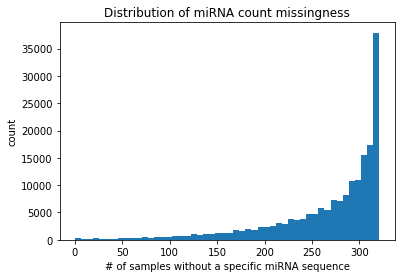

In [21]:
#missingness of gene matrix
num_missing_seq = gm_full.isna().sum(axis = 1)
plt.hist(num_missing_seq,bins=50)
plt.title('Distribution of miRNA count missingness')
plt.ylabel('count')
plt.xlabel('# of samples without a specific miRNA sequence')

Text(0.5, 0, '# of miRNA missing in a specific sample')

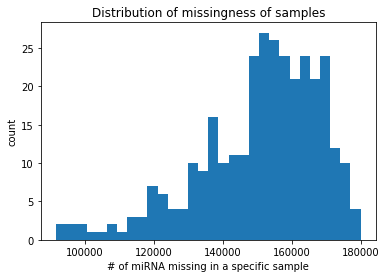

In [22]:

num_missing_samp = gm_full.isna().sum(axis = 0)
plt.hist(num_missing_samp, bins=30)
plt.title('Distribution of missingness of samples')
plt.ylabel('count')
plt.xlabel('# of miRNA missing in a specific sample')

In [23]:
split_info = gm.index.to_series().apply(lambda x: x.split(':')).reset_index(drop=True)
ids = split_info.apply(lambda x: x[0])
seq_type = split_info.apply(lambda x: x[1])
seq_name = split_info.apply(lambda x: x[2])
split_info = pd.DataFrame({'IDs':ids, 'Seq_type':seq_type, 'Seq_name':seq_name})
split_info.head()

,IDs,Seq_type,Seq_name
0,ENST00000538654.1,retained_intron,SNHG1-003
1,ENST00000516950.1,misc_RNA,Y_RNA.790-201
2,ENST00000363640.1,misc_RNA,RNY4P2-201
3,ENST00000363338.1,misc_RNA,Y_RNA.134-201
4,ENST00000365063.1,misc_RNA,Y_RNA.339-201


In [24]:
split_info.Seq_type.unique()

array(['retained_intron', 'misc_RNA', 'protein_coding', 'snRNA',
       'processed_pseudogene', 'processed_transcript', 'lincRNA',
       'snoRNA', 'antisense', 'Mt_tRNA', 'nonsense_mediated_decay',
       'pseudogene', 'transcribed_processed_pseudogene', 'Mt_rRNA'],
      dtype=object)

In [ ]:
# bar chart for the count of each type of seq

In [ ]:
# missingness of each type

In [193]:
gm_reind = gm.rename(index=dict(zip(gm.index, split_info.Seq_name))).T
gm_reind.head()

,SNHG1-003,Y_RNA.790-201,RNY4P2-201,Y_RNA.134-201,Y_RNA.339-201,EIF4A2-010,Y_RNA.110-201,SAR1A-001,CANX-201,RNVU1-18-201,Y_RNA.233-201,Y_RNA.491-201,Y_RNA.676-201,Y_RNA.391-201,EEF1A1P13-001,EEF1A1-014,RNU2-29P-201,RP11-553P9.1-001,RNU1-27P-201,RN7SL732P-201,Y_RNA.148-201,RNU12-001,RN7SL181P-201,Y_RNA.256-201,Y_RNA.481-201,Y_RNA.197-201,SNORD3B-2-001,Y_RNA.503-201,RNU2-61P-201,Y_RNA.125-201,Y_RNA.412-201,GNAS-201,SNORD3B-1-201,RNY4P17-201,Y_RNA.592-201,Y_RNA.311-201,RNY3-201,RNU1-1-201,Y_RNA.733-201,RNU1-67P-201,EEF1A1P5-001,RP11-640M9.1-006,MAPK1-001,HSPA8-025,RN7SL397P-201,HSPA8-008,RNY5-201,FTH1P20-001,C3-013,RPL3-002,MTRNR2L12-001,SNORD3B-2-201,NGDN-007,SAR1A-005,MT-TP-201,RN7SL40P-201,RPL37A-006,Y_RNA.724-201,EEF1A1-011,Y_RNA.211-201,MT-TS2-201,MALAT1-001,LINC00623-015,Y_RNA.161-201,SAR1A-007,RPL13A-003,SNORD3C-001,MT-TQ-201,CANX-202,RNVU1-13-201,RN7SL529P-201,EEF1A1-004,RNY4P30-201,RNU2-33P-201,EEF1G-002,RNVU1-15-201,Y_RNA.520-201,B2M-012,VTRNA2-1-001,RNU1-89P-201,EEF1A1P6-001,RN7SL183P-201,Y_RNA.499-201,EEF1A1-003,RN7SL752P-201,Y_RNA.740-201,Y_RNA.598-201,RNY4P29-201,Y_RNA.3-201,Y_RNA.44-201,RNY4P9-201,RPL37A-008,7SK.4-201,SCARNA15-001,EEF1G-001,RP11-353N4.6-007,Y_RNA.288-201,Y_RNA.118-201,Y_RNA.306-201,RPPH1-001,RPL3-012,SAR1A-202,Y_RNA.182-201,PABPC1-001,RNU2-37P-201,RPL3-003,Y_RNA.505-201,Y_RNA.710-201,SOD2-001,Y_RNA.490-201,RN7SL838P-201,Y_RNA.188-201,EEF1A1P22-001,Y_RNA.443-201,Y_RNA.383-201,EEF1G-201,RN7SL597P-201,RNU2-57P-201,RN7SK-201,HIST2H2AA4-001,LRP1-001,Y_RNA.667-201,RAD23B-001,TARDBP-001,RNY4P28-201,RN7SL43P-201,FTH1P10-002,RNU1-22P-201,RN7SL634P-201,SCARNA15-201,Y_RNA.121-201,RNU2-48P-201,SNORD99-201,Y_RNA.19-201,RP11-640M9.1-016,CANX-001,Y_RNA.291-201,RNU1-3-201,Y_RNA.550-201,SNORD95-201,RPS6-003,RNU5A-1-201,MT-TE-201,RNVU1-11-201,Y_RNA.479-201,RN7SL33P-201,RNY3P2-201,Y_RNA.784-201,ACTB-002,EEF1A1P12-001,RMRP-201,RNY4P3-201,Y_RNA.516-201,Y_RNA.249-201,ACTB-001,C1orf213-201,MT-TF-201,UBXN2A-001,MIR3654-001,RN7SL3-201,LA16c-360H6.3-001,RNY4P1-201,RN7SL277P-201,MT-TK-201,RPL37A-007,RNU11-201,Y_RNA.562-201,C3-001,RNU1-13P-201,WDR74-001,RN7SL296P-201,RN7SL128P-201,Y_RNA.255-201,EEF1A1-002,RPL37A-010,MT-TV-201,EEF1A1P5-201,Y_RNA.620-201,Y_RNA.130-201,RN7SL4P-201,EEF1A1-015,Y_RNA.730-201,RNVU1-9-201,Y_RNA.31-201,RAD23B-002,EEF1A1P9-001,CANX-004,RPL13A-008,AHNAK-005,MT-TT-201,Y_RNA.147-201,RNY4P6-201,RN7SL118P-201,Y_RNA.484-201,RNY4P18-201,RPS6-001,RNU1-2-201,Y_RNA.537-201,Y_RNA.665-201,TSTD3-201,EEF1A1-009,RNY4P25-201,B2M-001,Y_RNA.395-201,Y_RNA.24-201,RP11-6N17.2-001,FTH1-011,LINC00910-201,RPPH1-201,RPL13A-004,RN7SL8P-201,RPL37A-003,RNU1-4-201,SNORD104-201,Y_RNA.427-201,RPL37A-009,RNU2-64P-201,Y_RNA.807-201,WDR74-005,RNVU1-7-201,Y_RNA.20-201,NEAT1-001,LINC00623-016,RNY5P1-201,Y_RNA.532-201,Y_RNA.619-201,SCARNA3-201,RNU2-6P-201,PABPC1-012,Y_RNA.761-201,LINC00910-003,SNORD3D-001,RN7SL242P-201,Y_RNA.534-201,RNY4P8-201,Y_RNA.88-201,RPL3-001,Y_RNA.190-201,Y_RNA.450-201,FTH1-003,EEF1A1P4-001,RN7SL151P-201,Y_RNA.523-201,ACTB-003,RPL37A-004,ATP5G3-001,RNVU1-19-201,RN7SL502P-201,Y_RNA.320-201,RN7SL49P-201,FTH1-002,Y_RNA.751-201,SNORD3C-201,Y_RNA.52-201,Y_RNA.294-201,RNY4P16-201,RN7SL674P-201,PABPC1-002,Y_RNA.627-201,Y_RNA.781-201,SAR1A-003,RN7SL1-201,RNY4P14-201,RNY4-201,Y_RNA.170-201,RNU1-11P-201,EEF1A1P6-201,RNY5P8-201,RNVU1-1-201,Y_RNA.467-201,GNB2L1-017,EIF4A2-006,FTH1-007,Y_RNA.144-201,GNB2L1-014,C3-014,RPL37A-005,Y_RNA.472-201,Y_RNA.37-201,SNORD3D-201,Y_RNA.663-201,Y_RNA.262-201,Y_RNA.807-001,Y_RNA.666-201,RNY4P22-201,RN7SL396P-201,Y_RNA.241-201,RNU2-36P-201,MT-CO1-201,RN7SL395P-201,RN7SL300P-201,RNY4P7-201,RN7SL546P-201,Y_RNA.475-201,Y_RNA.688-201,RN7SL1-001,7SK.3-001,Y_RNA.71-201,MTRNR2L2-001,RNY3P6-201,RPL13A-002,FTH1-001,PAQR5-001,RN7SKP230-201,FTH1P10-001,RN7SL97P-201,RMRP-001,Y_RNA.79-201,C3-016,Y_RNA.477-201,Y_RNA.201-201,RNY4P11-201,PABPC1-003,Y_RNA.13-201,MT-TH-201,MT-TC-201,FTH1-008,ATAD5-001,Y_RNA.387-201,FTH1-010,RNY4P20-201,RNU12-201,RNY4P10-201,GNAS-017,RPL37A-011,VTRNA2-1-201,7SK.3-201,RN7SKP71-201

In [197]:
selected_ft = sra[['Run','CONDITION','expired_age', 'PMI', 'PlaqueTotal', 'TangleTotal',
                   'Braak score', 'sn_depigmentation']]
selected_ft = selected_ft.replace({'sn_depigmentation':{'none':0, 'nan':0, 'mild':1, 'moderate':2, 'severe':3},
                                   'Braak score':{'0':0, 'I':1, 'II':2, 'III':3, 'IV':4, 'V':5, 
                                                  'VI':6}}).set_index('Run')
alz_ft = selected_ft[selected_ft.CONDITION=='Alzheimer\'s Disease'].drop('CONDITION', axis=1)
park_ft = selected_ft[selected_ft.CONDITION=='Parkinson\'s Disease'].drop('CONDITION', axis=1)

alz_tbl = alz_ft.merge(gm_reind, left_index=True, right_index=True, how='inner')
park_tbl = park_ft.merge(gm_reind, left_index=True, right_index=True, how='inner')

num_fts = 6
alz_gm = alz_tbl.iloc[:, num_fts:]
park_gm = park_tbl.iloc[:, num_fts:]

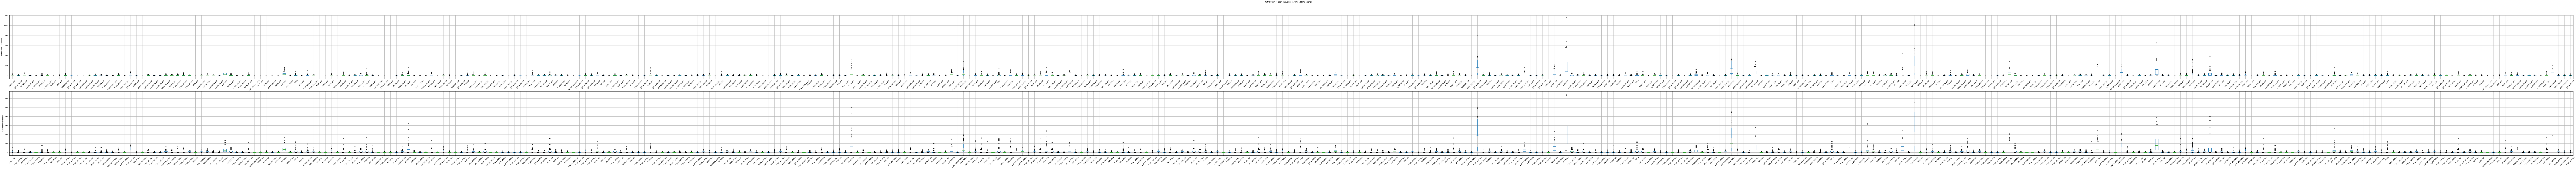

In [210]:
fig, axes= plt.subplots(nrows=2, ncols=1, figsize=(240, 16))
alz_gm.boxplot(ax = axes.flatten()[0])
axes.flatten()[0].set_xticklabels(alz_gm.columns, rotation=45)
park_gm.boxplot(ax = axes.flatten()[1])
axes.flatten()[1].set_xticklabels(park_gm.columns, rotation=45)
rows = ['Alzheimer\'s Disease','Parkinson\'s Disease']
for ax, row in zip(axes, rows):
    ax.set_ylabel(row, rotation=90, size='large')
fig.tight_layout()
fig.suptitle('Distribution of each sequence in AD and PD patients ')
fig.subplots_adjust(top=0.9)
plt.show()

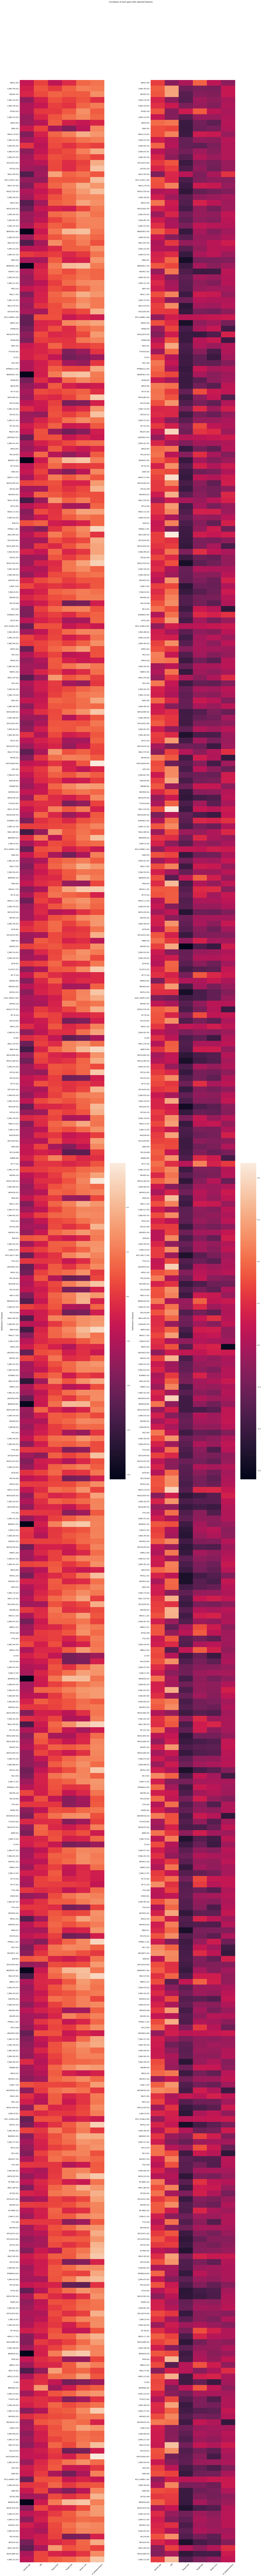

In [213]:
def get_corr_df(num_fts, fts_names, tbl):
    corr_df = pd.DataFrame()
    for i in range(num_fts):
        corr = tbl[tbl.columns[num_fts:]].apply(lambda x: x.corr(tbl.iloc[:,i]))
        corr_df[fts_names[i]] = corr
    return corr_df


fts_names = selected_ft.drop('CONDITION', axis=1).columns
tbl_arr = [alz_tbl, park_tbl]
cols = ['Alzheimer\'s Disease','Parkinson\'s Disease']
fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(24, 240))
ind = 0
for tbl in tbl_arr:
    corr_df = get_corr_df(num_fts, fts_names, tbl)
    sn.heatmap(corr_df, ax = axes.flatten()[ind])
    axes.flatten()[ind].set_xticklabels(fts_names, rotation=45)
    ind = ind+1

for ax, col in zip(axes, cols):
    ax.set_ylabel(col, rotation=90, size='large')
fig.tight_layout()
fig.suptitle('Correlation of each gene with selected features ')
fig.subplots_adjust(top=0.95)
plt.show()